## 2. 回答以下理论题目

## 2. 1.  What is autoencoder?

- AutoEncoder(自编码器，简称AE)，结合神经网络构成一套具有自动编码功能的模型
- 编码的本质是将信息从一种格式/形式转为另一种格式/形式的过程
- AutoEncoder是无监督学习，即学习过程不需要使用样本的label，本质上是把样本的输入同时作为神经网络的输入和输出，通过最小化重构误差希望学到样本的抽象特征表示 Vector


通过AutoEncoder 可以对高维数据进行高效特征提取和表示

### 2. 2. What are the differences between greedy search and beam search?

首先，这俩种都属于输出规则

- greedy 1-best search:称为贪婪搜索，输出的时候选择照概率最大的输出
- beam search: 称为集束搜索，选择概率最大的前 beam width（集束宽度）个可能结果，然后从中选择一个输出

### 2. 3. What is the intuition of attention mechanism?

2015年提出，让Encoder编码出的 c 向量跟Decoder 解码过程中的每一个输出进行加权运算，在Decoder 的每一个过程调整权重取到不一样的 C 向量


Attention 机制就是让Encoder 编码出来的向量根据 Decoder 要解码的内容动态变化，类似人的视觉在看某一个物体时的焦点，也就是对于重要部分设置更高的权重

### 2. 4. What is the disadvantage of word embedding introduced in previous lectures ?

Embedding的作用是可以将语义相似的词用相似的向量表示（向量夹角小），但是有个缺点，训练好之后每个单词的表达就固定住了，以后使用的时候，不论新句子上下文单词是什么，这个单词的 Word Embedding 不会跟着上下文场景的变化而变化，如：“我喜欢吃苹果”,“很多人觉得苹果手机好用”。这两个句子中的苹果是不同的语义，表示不同的对象，没有办法表示出来。

### 2. 5. Briefly describe what is self-attention and what is multi-head attention?

在计算能力有限的情况下，注意力机制（Attention Mechanism)作为一种资源分配方案，将有限的计算资源用来处理更重要的信息，可以解决信息超载问题。
- self Attention： 可以不仅可以得到源端与目标端词与词之间的依赖关系，同时还可以有效获取源端或目标端自身词与词之前的依赖关系。
- multi-head attention:多头注意力是利用多个查询 Q = [q1,...$ q_M $]，来并行地从输入信息中选取多组信息，每个注意力关注输入信息的不同部分。

## 3. 中英文自动翻译模型的构建（使用encoder-decoder模型）

<h3>3.1 导入需要的模块及数据</h3>

In [7]:
from __future__ import unicode_literals, print_function, division
from io import open  # Python的 io 模块提供了多个流式处理接口
import unicodedata   #用来处理 Unicode 编码的数字
import string
import re
import random
import jieba
# import nltk

import torch

import torch.nn as nn
from torch import optim
import torch.nn.functional as F


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

<h3>3.2 预处理数据</h3>

In [8]:
SOS_token = 0
EOS_token = 1

# 定义处理语言数据的字典映射类
class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}  # 用来做单词字典的，即使得 单词 -->索引
        self.word2count = {}  # 用来统计每个单词出现的次数
        self.index2word = {0: "SOS", 1: "EOS"}  # 用来反向翻译的字典，即使 索引-->单词
        self.n_words = 2  # Count SOS and EOS  # 用来统计最后的单词数目

    def addSentence(self, sentence):            
        for word in sentence.split(' '):
#         for word in nltk.word_tokenize(sentence.lower()):
            self.addWord(word)
    
    def addSentence_cn(self, sentence):
        for word in list(jieba.cut(sentence)):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1 
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [9]:
# 为便于数据处理，把 Unicode字符串转换为 ASCII 编码

def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)  #  NFD表示字符应该分解为多个组合字符表示
        if unicodedata.category(c) != 'Mn'  # Mn代表的是标记、非间距的
    )

# 对英文转换为小写，去空格及非字母符号等处理
# 在这里是否考虑可以采用 nltk 的方式来进行处理貌似区别不大

def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    return s

In [10]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # 读文件，然后分成行

    lines = open('F:/Jupyter_notebook_workdir/微软九步AI学习法-人工智能核心知识强化课程/week5/seq2seq_keras/data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
            read().strip().split('\n')


    # 把行分成语句对，并进行规范化
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # 判断是否需要转换语句对的次序，如[英文，中文]转换为[中文，英文]次序，增加代码的复用性
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

In [11]:
#为便于训练，这里选择部分特征明显的数据
MAX_LENGTH = 20

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)

# 这里面选择长度小于20并且英文部分的开始是以特定的前缀开始的
def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [12]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence_cn(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)  
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

In [13]:
# 查看下数据是否已经预处理完成
input_lang, output_lang, pairs = prepareData('eng', 'cmn',True)
print(random.choice(pairs))

Reading lines...


Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\CK\AppData\Local\Temp\jieba.cache


Read 20133 sentence pairs
Trimmed to 632 sentence pairs
Counting words...


Loading model cost 0.643 seconds.
Prefix dict has been built successfully.


Counted words:
cmn 1060
eng 808
['她不习惯长时间驾车。', 'she is not accustomed to driving for a long time .']


In [14]:
pairs[:3]

[['我冷。', 'i am cold .'], ['我沒事。', 'i am okay .'], ['我生病了。', 'i am sick .']]

<h3>3.3 构建模型</h3>

In [15]:
# 构建 Encoder 模型
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)  # 转化为词向量
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [16]:
# 构建注意力 Decoder 
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        # 定义参数
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length
        
        # 定义层
        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)
        

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)  # 最后输出 y(i - 1)作为嵌入层的输入
        embedded = self.dropout(embedded)
        
        # 计算注意力权重并使用编码器输出
        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))
        
        # 把词嵌入与注意力 context 结合到一起，然后传入循环网络
        # 定义最后输出层
        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        # 返回最后输出、隐含状态及注意力权重
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [17]:
# 构建训练数据集
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

def indexesFromSentence_cn(lang, sentence):
    return [lang.word2index[word] for word in list(jieba.cut(sentence))]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)

def tensorFromSentence_cn(lang, sentence):
    indexes = indexesFromSentence_cn(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence_cn(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

<h3>3.4 训练模型</h3>

In [18]:
teacher_forcing_ratio = 0.5


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [19]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [20]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  
    plot_loss_total = 0 

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

In [30]:
import matplotlib.pyplot as plt
%matplotlib inline

#plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)
    plt.savefig('loss_curve')

In [31]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence_cn(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

In [23]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

3m 16s (- 45m 48s) (5000 6%) 2.6422
6m 23s (- 41m 30s) (10000 13%) 1.1603
9m 32s (- 38m 11s) (15000 20%) 0.2129
12m 43s (- 35m 0s) (20000 26%) 0.0503
15m 59s (- 31m 58s) (25000 33%) 0.0288
19m 8s (- 28m 43s) (30000 40%) 0.0213
22m 18s (- 25m 29s) (35000 46%) 0.0168
25m 27s (- 22m 16s) (40000 53%) 0.0179
28m 37s (- 19m 5s) (45000 60%) 0.0162
31m 50s (- 15m 55s) (50000 66%) 0.0139
34m 59s (- 12m 43s) (55000 73%) 0.0123
38m 8s (- 9m 32s) (60000 80%) 0.0118
41m 17s (- 6m 21s) (65000 86%) 0.0116
44m 25s (- 3m 10s) (70000 93%) 0.0115
47m 34s (- 0m 0s) (75000 100%) 0.0124


<Figure size 432x288 with 0 Axes>

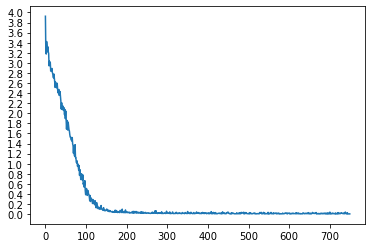

In [24]:
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

trainIters(encoder1, attn_decoder1, 75000, print_every=5000)

<h3>3.5随机采样，对模型进行测试</h3>

In [25]:
evaluateRandomly(encoder1, attn_decoder1)

> 你只是說說而已。
= you are just saying that .
< you are just saying that . <EOS>

> 他不是我的兄弟。他是我的表弟。
= he isn't my brother . he's my cousin .
< he isn't my brother . he's my cousin . <EOS>

> 他是一位著名的棒球選手。
= he is a famous baseball player .
< he is a famous baseball player . <EOS>

> 她不總是高興。
= she is not always happy .
< she is not always happy . <EOS>

> 她正在找她不見了的皮夾。
= she is looking for her missing wallet .
< she is looking for her missing wallet . <EOS>

> 你很聰明。
= you are sharp .
< you are sharp . <EOS>

> 她沉迷于摇滚乐。
= she is absorbed in rock music .
< she is absorbed in rock music . <EOS>

> 她没像你那样有耐心。
= she is not as patient as you .
< she is not as patient as you . <EOS>

> 我们很高兴再次见到你。
= we are happy to see you again .
< we are happy to see you again . <EOS>

> 他總是忘記事情。
= he is always forgetting things .
< he is always forgetting things . <EOS>



<h3>3.6可视化注意力</h3>

In [40]:

def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + list(jieba.cut(input_sentence)) +
                       ['<EOS>'], rotation=90,fontproperties=myfont)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

input = 我很幸福。
output = i am very sad . <EOS>


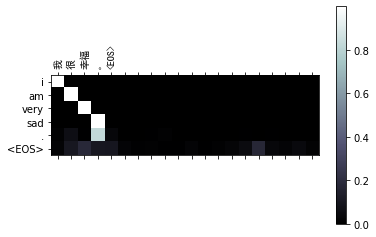

input = 我们在严肃地谈论你的未来。
output = we are having a serious talk about your future . <EOS>


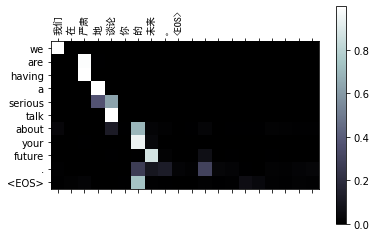

input = 我在家。
output = i am at home . <EOS>


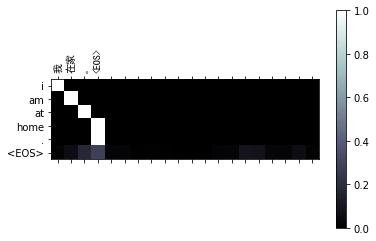

input = 我们在严肃地谈论你的未来。
output = we are having a serious talk about your future . <EOS>


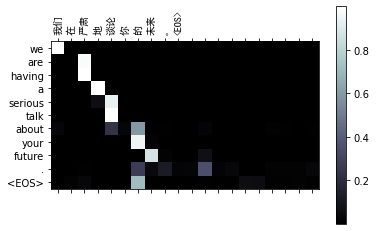

In [41]:
def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(
        encoder1, attn_decoder1, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)


evaluateAndShowAttention("我很幸福。")

evaluateAndShowAttention("我们在严肃地谈论你的未来。")

evaluateAndShowAttention("我在家。")

evaluateAndShowAttention("我们在严肃地谈论你的未来。")